In [1]:
# It is well known that most time series have inherent temporal structure where 
# succeeding observations are dependent on the previous n observations in time i.e. autocorrelation. 
# A wise choice therefore, might be to model the trend using TFP STS’s SemiLocalLinearTrend model. 
# In a semi-local linear trend model, the slopecomponent evolves according to a first-order autoregressive process.
# The AR process can therefore account for the autocorrelative (of order n) effect 
# in the time series, and typically lead to forecasts with greater certainty over a longer period of time.
# LocalLinearTrend model.
# SemiLocalLinearTrend model. 

### Dependencies & Prerequisites


In [1]:
import time
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
from hill_regression import HillRegression

tf.enable_v2_behavior()
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


2023-05-06 16:30:28.039407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 16:30:28.165949: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2023-05-06 16:30:30.471593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 16:30:30.507245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 16:30:30.621361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 16:30:30.624847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

### Plotting setup

Helper methods for plotting time series and forecasts.

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [4]:
from aim_functions import plot_forecast
from aim_functions import plot_components
from aim_functions import plot_one_step_predictive
from aim_functions import transformData

In [5]:
start_date = '2022-09-07'
drop_networks_after = 14

sales_data = pd.read_csv('Install_data.csv', index_col='FullDate')
sales_data.index = pd.to_datetime(sales_data.index)
sales_data = sales_data.asfreq('D')
sales_data = sales_data.loc[:datetime.strptime(start_date, '%Y-%m-%d'), :].copy()

# # drop networks that are no longer being used.
# # determine the last 14 rows of the dataframe
last_14_rows = sales_data.tail(drop_networks_after)
# # create a list of columns with only zeros for the last 14 rows
cols_to_drop = [col for col in sales_data.columns if (last_14_rows[col] == 0).all()]
# # remove the columns from the original dataframe
sales_data = sales_data.drop(cols_to_drop, axis=1)

sales_dates = np.array(sales_data.index.values)
last_date = np.max(sales_dates)
last_date = pd.to_datetime(last_date) + timedelta(days=1)
last_date = last_date.strftime('%Y-%m-%d')
sales_dates = np.arange('2018-01-01', last_date, dtype='datetime64')

sales_fmt = mdates.DateFormatter('%a %b %d')

# # models=['linear','log']
model='linear'

TotalCost_cols=[col for col in sales_data.columns if 'TotalCost_' in col]
DayOfWeek_cols=[col for col in sales_data.columns if 'DayOfWeek_' in col]
Holiday_cols=[col for col in sales_data.columns if 'Holiday_' in col]
Endo_cols=[col for col in sales_data.columns if 'dep_' in col]
EnEx_cols = Endo_cols + TotalCost_cols
Eng_cols = DayOfWeek_cols + Holiday_cols

sales_data[EnEx_cols] = sales_data[EnEx_cols].values.astype('float32')
sales_data[Eng_cols] = sales_data[Eng_cols].values.astype('int32')

# Pre-process data
sales_scaled = pd.DataFrame(data=sales_data)
sales_scaled = sales_scaled.asfreq('D')
# Don't transform the data if the CSV file contains transformed data
# sales_scaled = transformData(sales_scaled.asfreq('D'), model)

In [18]:
sales_scaled.tail() # 52

dep_AdjustedInstalls  TotalCost_Aarkirtb  TotalCost_Adaction   
FullDate                                                                   
2022-09-03             10.961365            0.190542            0.027042  \
2022-09-04             10.951526            0.193409            0.024145   
2022-09-05             10.944188            0.215288            0.018592   
2022-09-06             10.816132            0.203483            0.029457   
2022-09-07             10.762742            0.197497            0.017384   

            TotalCost_Adcolony  TotalCost_Adikteev  TotalCost_Adjoe   
FullDate                                                              
2022-09-03            0.358169            0.236785         0.621611  \
2022-09-04            0.123506            0.244500         0.676801   
2022-09-05            0.000000            0.237687         0.620062   
2022-09-06            0.000000            0.236128         0.573005   
2022-09-07            0.000000            0.221239         0.541073   

            TotalCost_Adwords  TotalCost_Applifier  TotalCost_Digitalturbine   
FullDate                                                                       
2022-09-03           0.247733             0.250236                  0.408527  \
2022-09-04           0.246835             0.266737                  0.370085   
2022-09-05           0.344023             0.270797                  0.360519   
2022-09-06           0.226752             0.241696                  0.324915   
2022-09-07           0.229477             0.225311                  0.334738   

            TotalCost_Facebook  ...  TotalCost_Vungle  DayOfWeek_1   
FullDate                        ...                                  
2022-09-03            0.220436  ...          0.133743            0  \
2022-09-04            0.220217  ...          0.169731            0   
2022-09-05            0.215354  ...          0.151625            0   
2022-09-06            0.212122  ...          0.095637            1   
2022-09-07            0.190367  ...          0.136403            0   

            DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6   
FullDate                                                                      
2022-09-03            0            0            0            1            0  \
2022-09-04            0            0            0            0            1   
2022-09-05            0            0            0            0            0   
2022-09-06            0            0            0            0            0   
2022-09-07            1            0            0            0            0   

            Holiday_laborday  Holiday_laborday_DayAfter   
FullDate                                                  
2022-09-03                 0                          0  \
2022-09-04                 0                          0   
2022-09-05                 1                          0   
2022-09-06                 0                          1   
2022-09-07                 0                          0   

            Holiday_laborday_DayBefore  
FullDate                                
2022-09-03                           0  
2022-09-04                           1  
2022-09-05                           0  
2022-09-06                           0  
2022-09-07                           0  

[5 rows x 33 columns]

In [19]:
sales_scaled["dep_AdjustedInstalls"]

FullDate
2018-01-01    11.347355
2018-01-02    11.218568
2018-01-03    11.057377
2018-01-04    11.100934
2018-01-05    11.111418
                ...    
2022-09-03    10.961365
2022-09-04    10.951526
2022-09-05    10.944188
2022-09-06    10.816132
2022-09-07    10.762742
Freq: D, Name: dep_AdjustedInstalls, Length: 1711, dtype: float32

In [6]:
num_forecast_steps = 7 * 2 # Two weeks.
sales_training_data = sales_scaled["dep_AdjustedInstalls"][:-num_forecast_steps]
sales_testing_data = sales_scaled["dep_AdjustedInstalls"][-num_forecast_steps:]


sales_exog_data_training = sales_scaled.iloc[:,1:][:-num_forecast_steps]
# sales_exog_data_testing = sales_scaled.iloc[:,1:][-num_forecast_steps:]

In [7]:
sales_exog_data_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1697 entries, 2018-01-01 to 2022-08-24
Freq: D
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TotalCost_Aarkirtb           1697 non-null   float32
 1   TotalCost_Adaction           1697 non-null   float32
 2   TotalCost_Adcolony           1697 non-null   float32
 3   TotalCost_Adikteev           1697 non-null   float32
 4   TotalCost_Adjoe              1697 non-null   float32
 5   TotalCost_Adwords            1697 non-null   float32
 6   TotalCost_Applifier          1697 non-null   float32
 7   TotalCost_Digitalturbine     1697 non-null   float32
 8   TotalCost_Facebook           1697 non-null   float32
 9   TotalCost_Ironsourcepreload  1697 non-null   float32
 10  TotalCost_Lifestreetrtb      1697 non-null   float32
 11  TotalCost_Liftoffrtb         1697 non-null   float32
 12  TotalCost_Mintegral          1697 non-null   float

visual inspection of time series

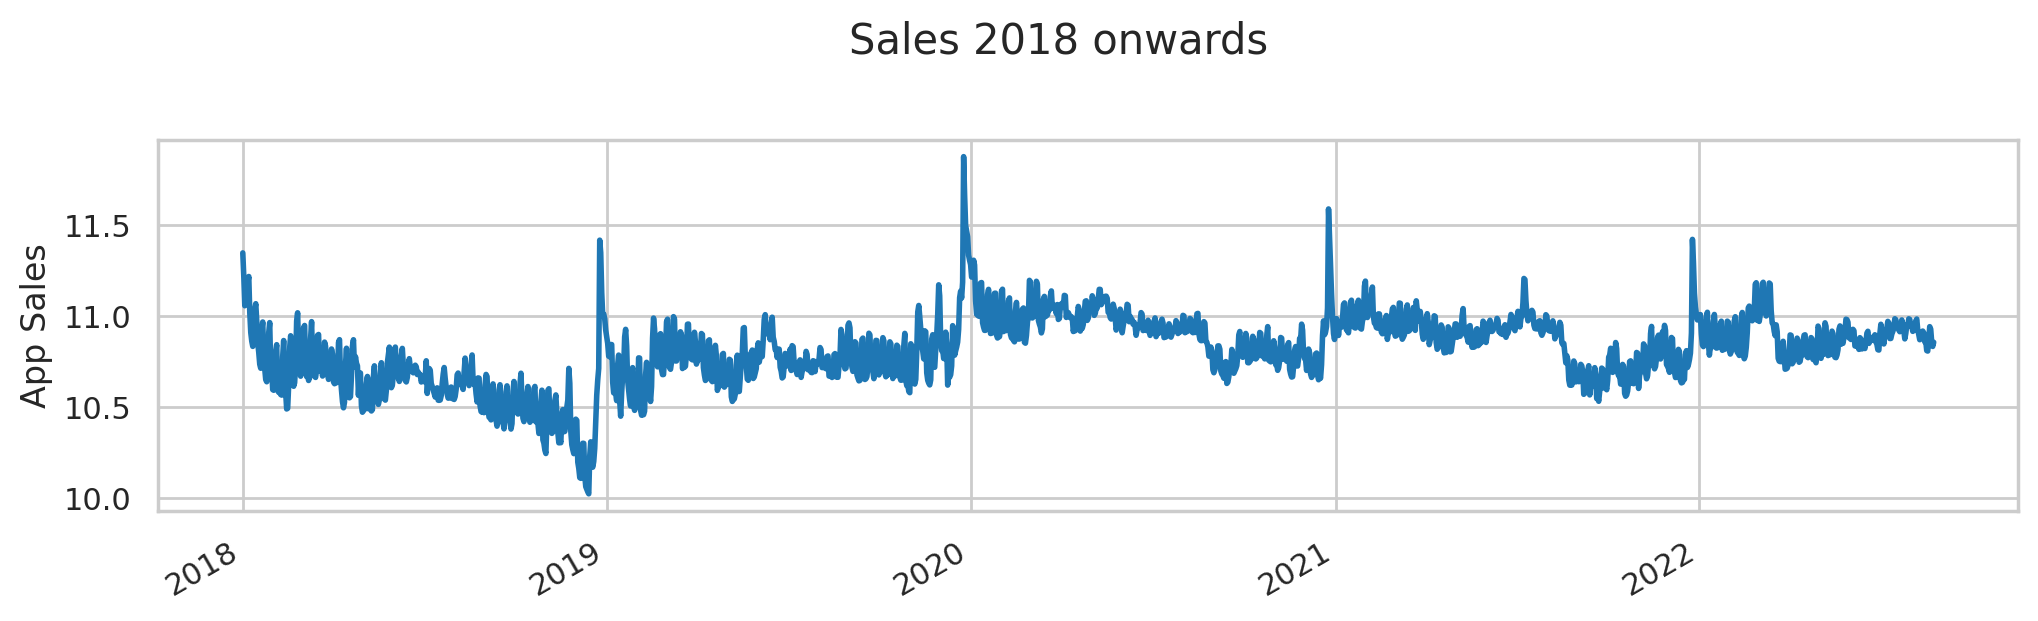

In [7]:
sales = sales_scaled['dep_AdjustedInstalls'].values

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(sales_dates[:-num_forecast_steps],
        sales[:-num_forecast_steps], lw=2, label="training data")
ax.set_ylabel("App Sales")

fig.suptitle("Sales 2018 onwards",
             fontsize=15)
fig.autofmt_xdate()

In [11]:
# Is the data stationary?
# !pip install pmdarima
# from pmdarima.arima import ADFTest
# adf_test = ADFTest(alpha = 0.05)
# adf_test.should_diff(sales_scaled["dep_AdjustedInstalls"])
# #Not stationary...

time series decomposition

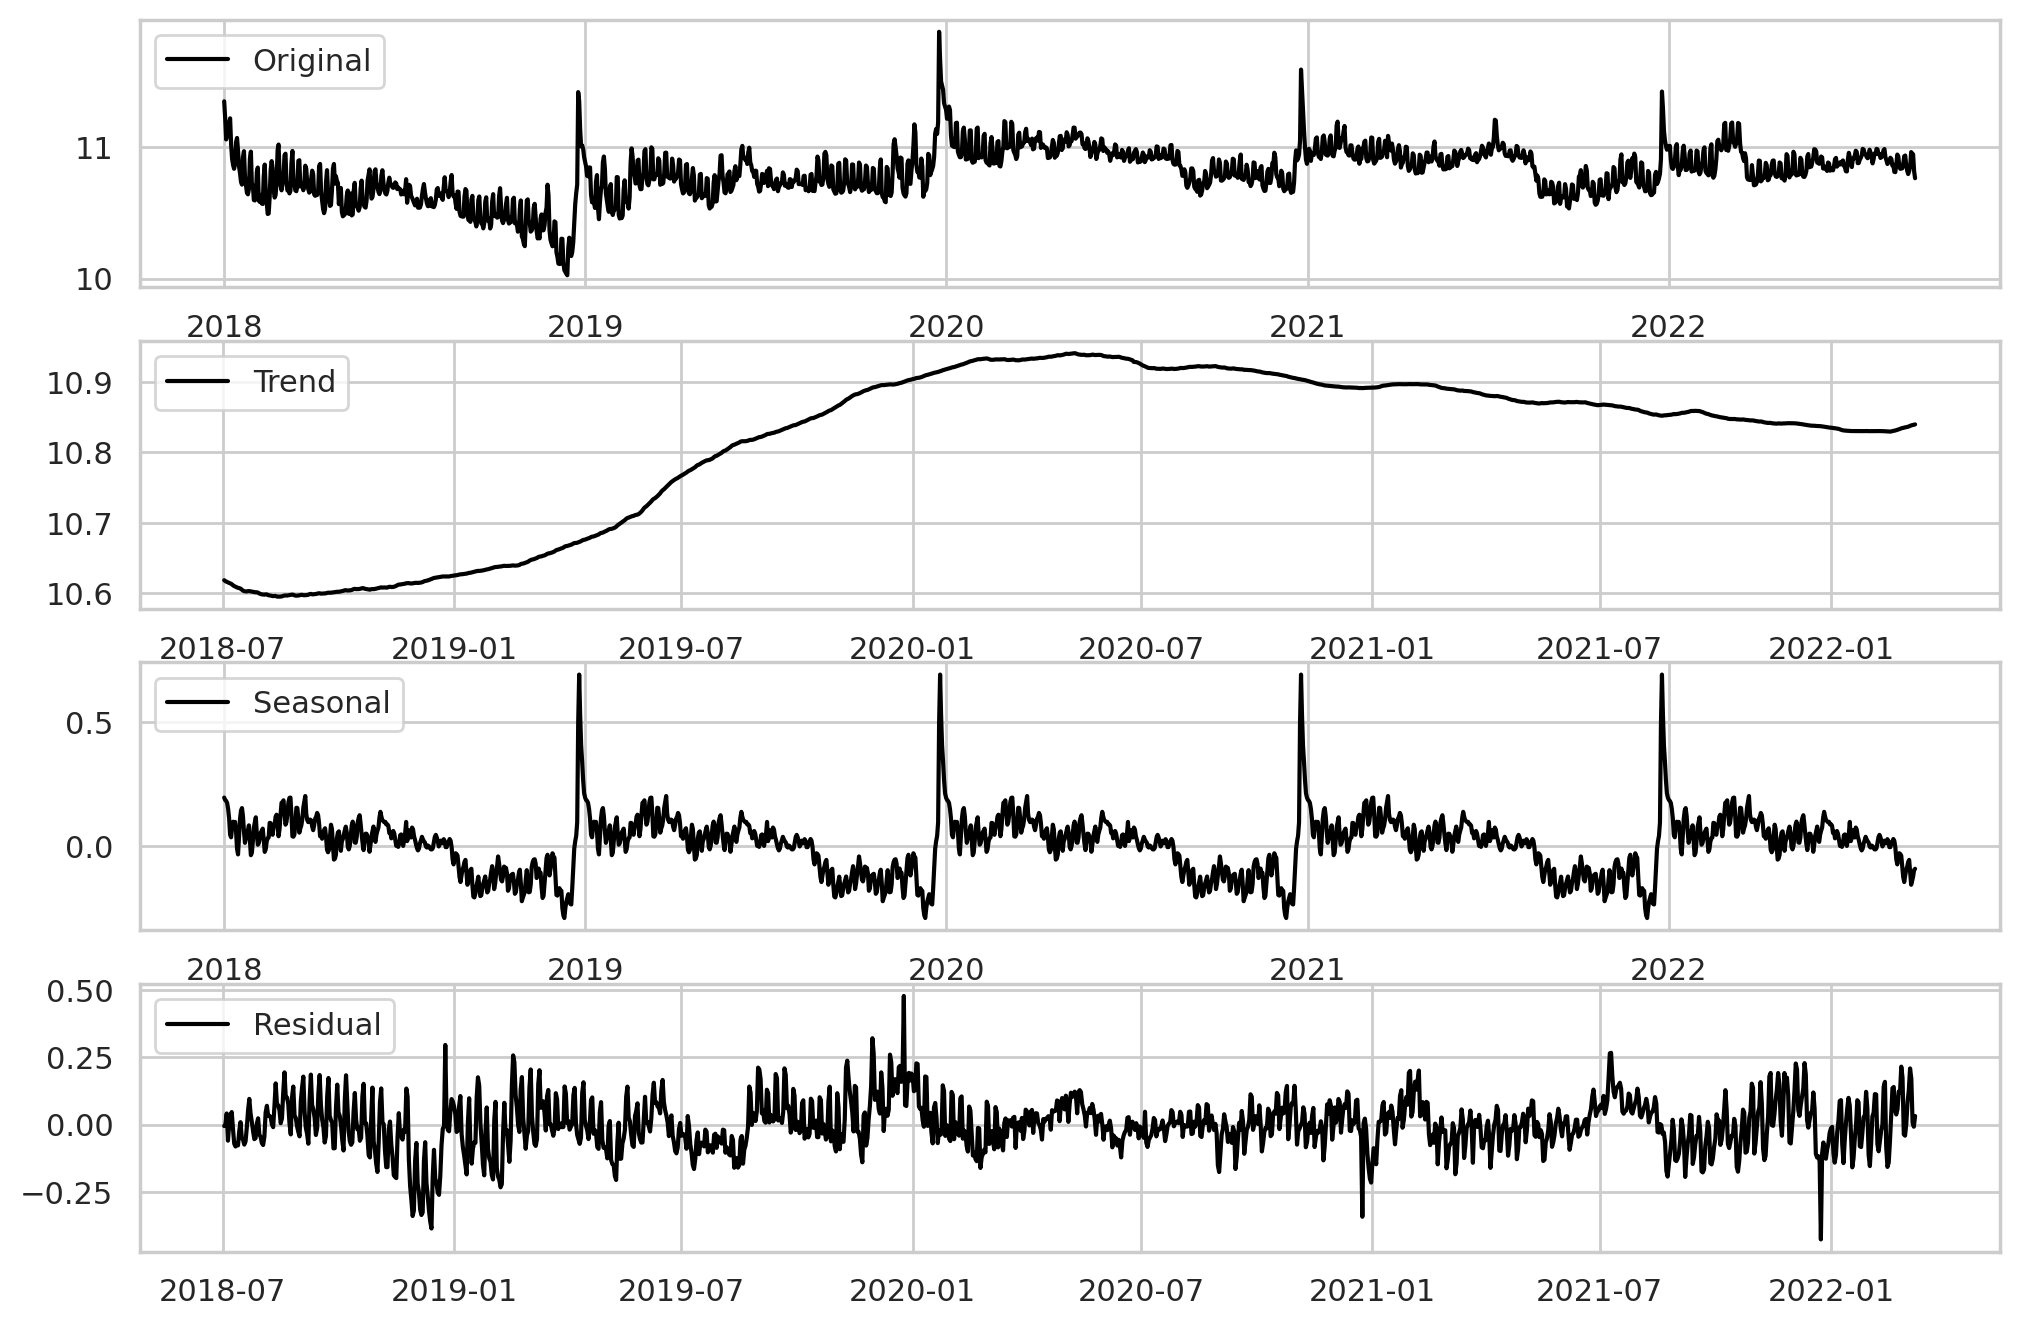

In [8]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(sales_scaled['dep_AdjustedInstalls'],  model ='additive',period=365)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(sales_scaled["dep_AdjustedInstalls"], label='Original', color='black')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='black')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='black')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()

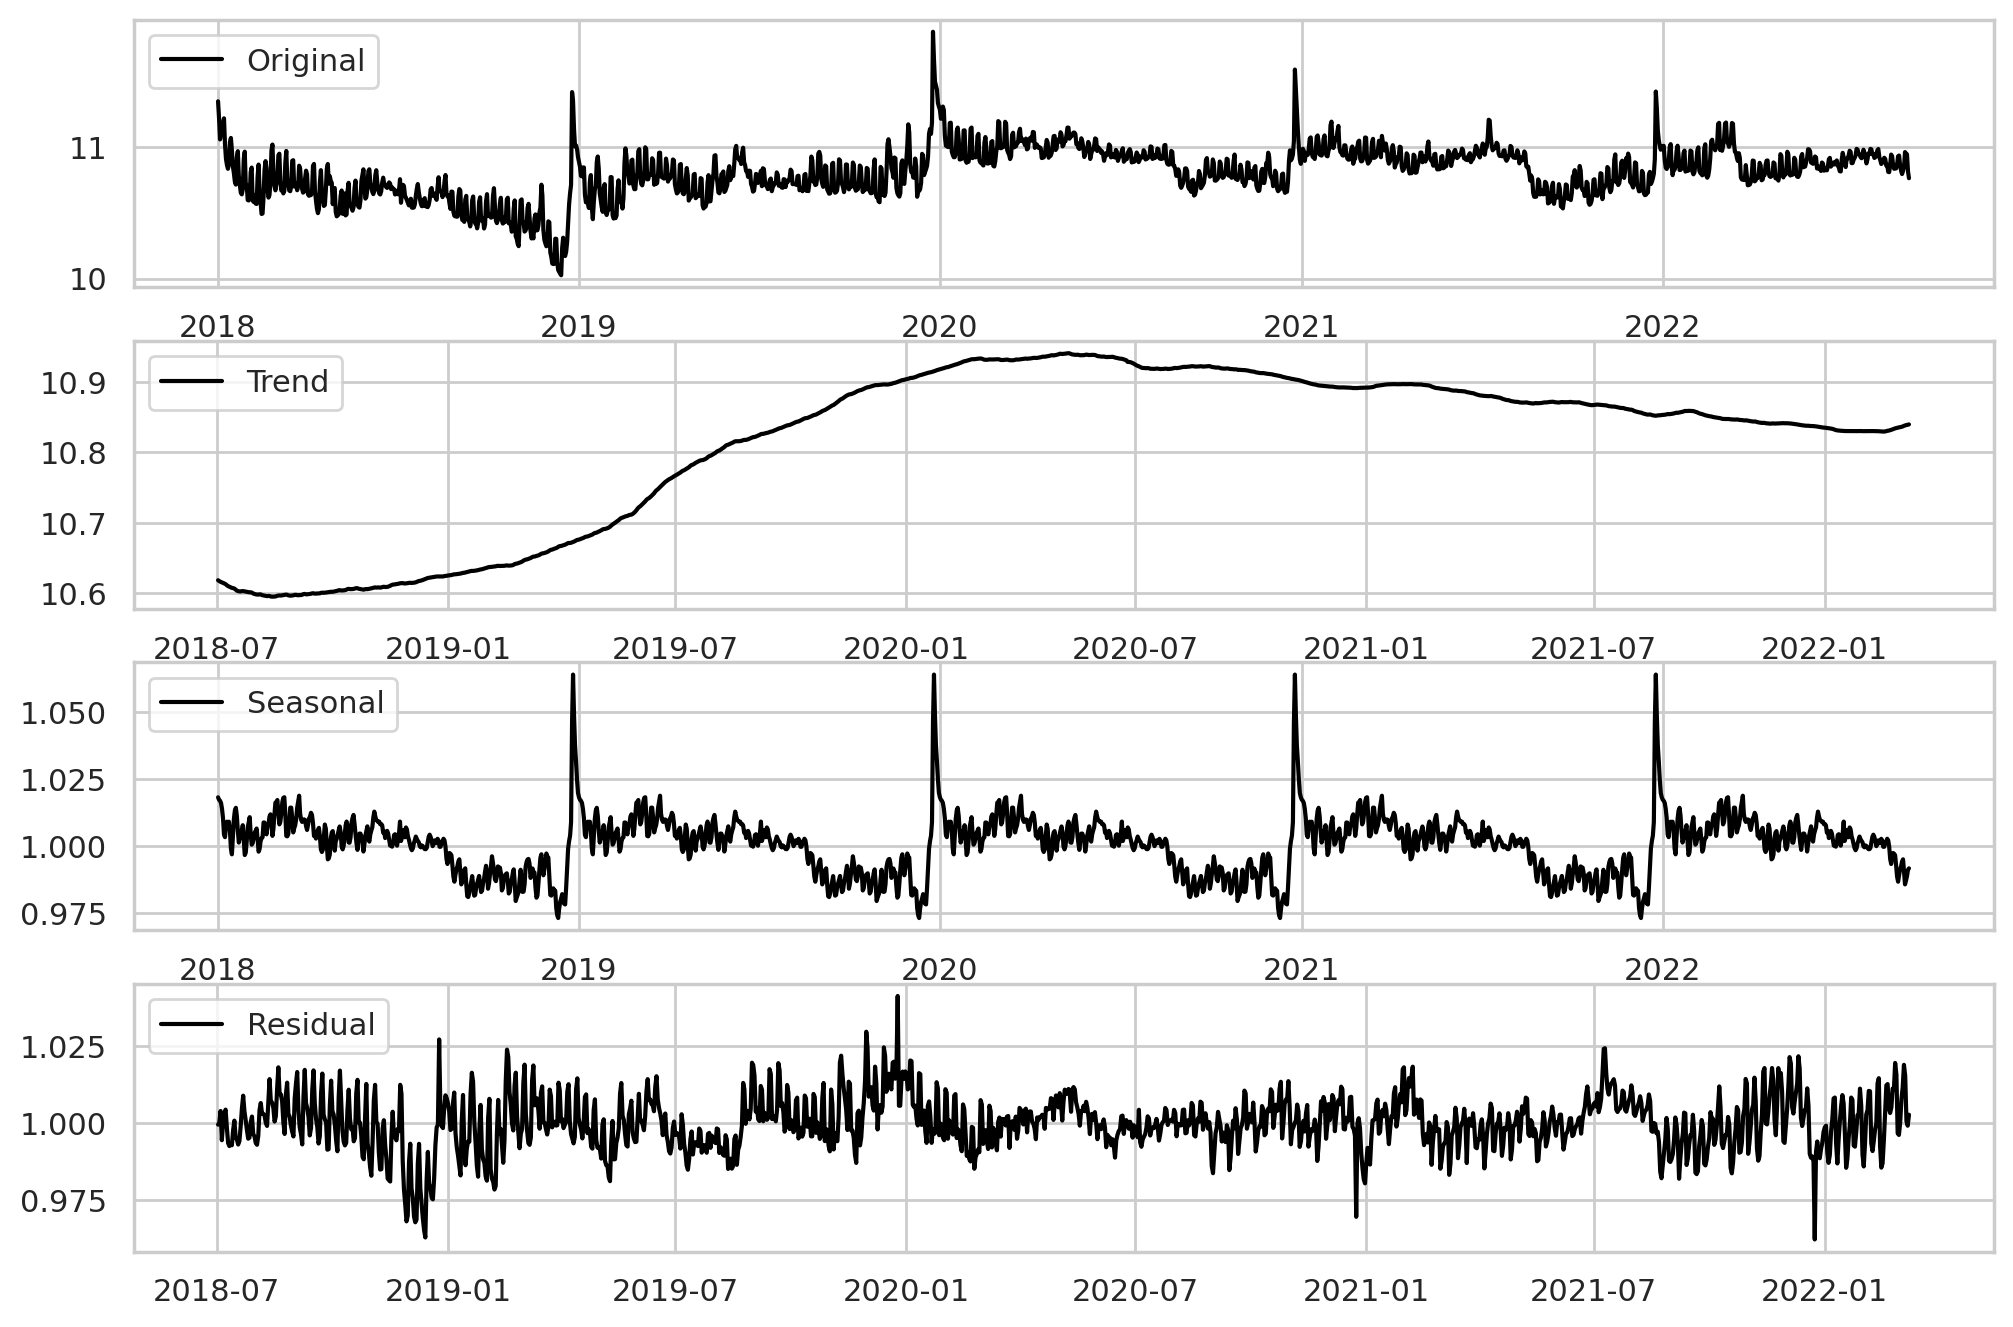

In [9]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(sales_scaled['dep_AdjustedInstalls'],  model ='multiplicative',period=365)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(sales_scaled["dep_AdjustedInstalls"], label='Original', color='black')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='black')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='black')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()

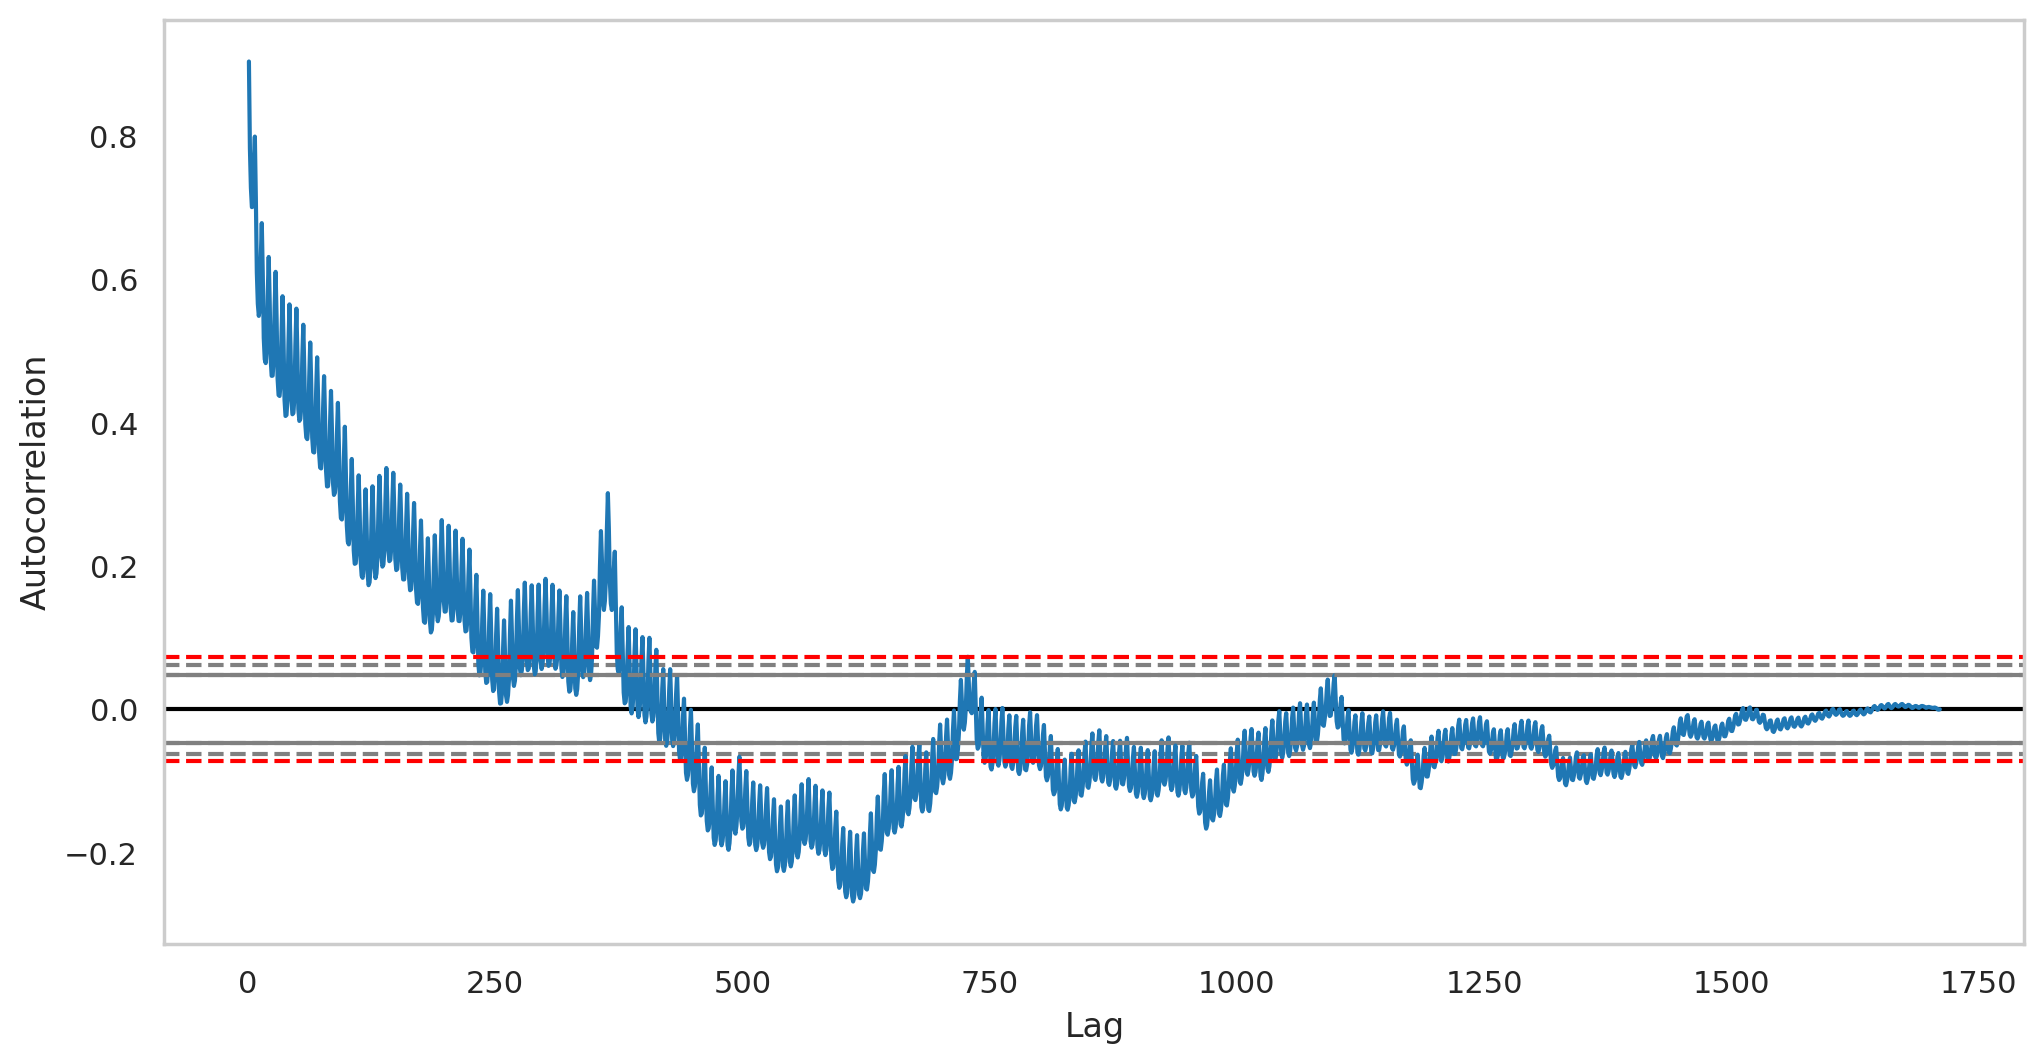

In [9]:
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
# Generate autocorrelation plot
fig, ax = plt.subplots(figsize=(12, 6))
autocorrelation_plot(sales_scaled["dep_AdjustedInstalls"], ax=ax) 
ax.axhline(y=-1.96/np.sqrt(len(sales_scaled["dep_AdjustedInstalls"])), linestyle='--', color='gray')
ax.axhline(y=1.96/np.sqrt(len(sales_scaled["dep_AdjustedInstalls"])), linestyle='--', color='gray')
ax.axhline(y=-3.0/np.sqrt(len(sales_scaled["dep_AdjustedInstalls"])), linestyle='--', color='red')
ax.axhline(y=3.0/np.sqrt(len(sales_scaled["dep_AdjustedInstalls"])), linestyle='--', color='red')
plt.show()
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

#A strong positive correlation for lags below 40 (months)

In [10]:
# specify the order of ar and ma in arima

# Let's try to make an Auto Regressive Moving Average model

# this code find best paramaters for Ar(p) and Ma(q)
from pmdarima.arima import auto_arima

model = auto_arima(sales_training_data, 
                      start_p=1, 
                      start_q=1,
                      test='adf',
                      max_p=10, 
                      max_q=10,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3730.002, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3578.617, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3608.815, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3668.798, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3580.597, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3964.040, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3857.838, Time=0.14 sec


KeyboardInterrupt: 

# Hill regression testing

### Model and fitting

In [11]:
def build_model(observed_time_series, exog_data, num_comp):

    Holidays=[col for col in exog_data.columns if 'Holiday_' in col]
    NetworkCost=[col for col in exog_data.columns if 'TotalCost_' in col]

    # Create a dictionary of variable names and their values
    network_effect_dict = {}
    for col in NetworkCost:
        network_effect_dict[col+'_effect'] = HillRegression(
            design_matrix=tf.stack((exog_data[[col]]-exog_data[[col]].mean()).values),
            weights_prior=tfd.HalfNormal(scale=np.float32(0.5)),
            name=col+'_effect')

    # Convert the dictionary to a list of variables
    network_effect_list = [value for key, value in network_effect_dict.items()]

    num_days_per_month = np.array(
        [[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
         [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
         [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],  # year with leap day
         [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
         [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]])

    smooth_seasonal = sts.SmoothSeasonal(
        period=365.25,  # Annual period
        observed_time_series=observed_time_series,
        frequency_multipliers=[1, 2, 3],
        name='smooth_seasonal'
    )

    month_of_year = tfp.sts.Seasonal(
        num_seasons=12,
        #num_steps_per_season=num_days_per_month,
        drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
        initial_effect_prior=tfd.Normal(loc=0., scale=5.),
        observed_time_series=observed_time_series,
        name='month_of_year')

    day_of_week_effect = tfp.sts.Seasonal(
        num_seasons=7, 
        num_steps_per_season=1,
        observed_time_series=observed_time_series,
        name='day_of_week_effect')

    holiday_effect = tfp.sts.LinearRegression(
        design_matrix=tf.cast(exog_data[Holidays].values, tf.float32),
        name='holiday_effects')

    week_effect = tfp.sts.LinearRegression(
        design_matrix=tf.cast(exog_data[DayOfWeek_cols].values, tf.float32),
        name='week_effect')
   
    spend_effect = tfp.sts.LinearRegression(
        # To simplify and speed up inference, use the design matrix with a single exogenous regressor
        # Comment in/out the follow two lines to select whether you want one or 40+ exog features.
        # design_matrix=tf.stack((exog_data[['TotalCost_F']]-exog_data[['TotalCost_F']].mean()).values),
        design_matrix=tf.stack((exog_data[NetworkCost]-exog_data[NetworkCost].mean()).values),
        weights_prior=tfd.HalfNormal(scale=np.float32(0.5)),
        name='spend_effect')

    # The new class would be called here:
    spend_hill_effect = HillRegression(
        design_matrix=tf.stack((exog_data[NetworkCost]-exog_data[NetworkCost].mean()).values),
        weights_prior=tfd.HalfNormal(scale=np.float32(0.5)),
        name='spend_hill_effect')

    autoregressive = tfp.sts.Autoregressive(
        order=7,
        observed_time_series=observed_time_series,
        name='autoregressive')

    arima = tfp.sts.AutoregressiveIntegratedMovingAverage(
        ar_order=7,
        ma_order=7,
        integration_degree=1,
        observed_time_series=observed_time_series,
        name='arima')
    
    
    model_components = [
        # month_of_year,
        smooth_seasonal,
        # day_of_week_effect,
        holiday_effect,
        week_effect,
        # spend_effect,
        # spend_hill_effect, # New component would be included here
        # TotalCost_Aarkirtb_effect,
        # TotalCost_Adwords_effect,
        # TotalCost_Applifier_effect,
        arima
    ]+network_effect_list
    print("length of network_effect_list", len(network_effect_list))
    print("lenght of current model component", len(model_components[:num_comp]))
    model = tfp.sts.Sum(model_components[:num_comp],
                    observed_time_series=observed_time_series)
    return model


exog = Holiday_cols + TotalCost_cols
sales_model = build_model(sales_training_data, sales_exog_data_training, num_comp=4)

2023-05-06 16:30:58.234580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 16:30:58.235412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 16:30:58.236127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 16:30:58.237156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 16:30:58.237892: I tensorflow/compiler/xla/stream_executo

length of network_effect_list 23
lenght of current model component 4


## Fit with variational inference

grid search

In [13]:
# Define the grid search function
def grid_search(learning_rates, num_samples, surrogate_posterior, num_steps, sale_data=sales_training_data, sale_exog=sales_exog_data_training, num_forecast_steps=14):
    best_loss_train = float("inf")
    best_mean_absolute_percentage_error = float("inf")
    best_lr = None
    best_num_samples = None
   
    for lr in learning_rates:
        for n in num_samples:
                optimizer = tf.optimizers.Adam(learning_rate=lr)  
                sales_model = build_model(sale_data, sale_exog, num_comp=4)             
                elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
                    target_log_prob_fn=sales_model.joint_distribution(observed_time_series=sale_data).log_prob,
                    surrogate_posterior=variational_posteriors,
                    optimizer=tf.optimizers.Adam(lr),
                    num_steps=num_steps,
                    sample_size=n,
                    jit_compile=True)
                # elbo_loss_curve = tfp.vi.fit_surrogate_posterior( 
                #     target_log_prob_fn, 
                #     surrogate_posterior, 
                #     optimizer=tf.optimizers.Adam(lr), 
                #     num_steps=100) 

                # Draw samples from the variational posterior.
                q_samples_sales_ = variational_posteriors.sample(50)
                print("Inferred parameters:")
                for param in sales_model.parameters:
                    print("{}: {} +- {}".format(param.name,
                                                np.mean(q_samples_sales_[param.name], axis=0),
                                                np.std(q_samples_sales_[param.name], axis=0)))       

                sales_forecast_dist = tfp.sts.forecast(
                    model=sales_model,
                    observed_time_series=sale_data,
                    parameter_samples=q_samples_sales_,
                    num_steps_forecast=num_forecast_steps)

                true_values = np.exp(sales_scaled['dep_AdjustedInstalls'][-num_forecast_steps:].values)
                forecast = np.exp(sales_forecast_dist.mean())
                mean_absolute_percentage_error = tf.reduce_mean(tf.abs(forecast - true_values) / true_values) * 100
                print(f"Mean absolute percentage error: {mean_absolute_percentage_error:.3f}%")

                final_loss = elbo_loss_curve[-1]
                if  mean_absolute_percentage_error < best_mean_absolute_percentage_error:
                    best_mean_absolute_percentage_error=mean_absolute_percentage_error
                    best_loss_train = final_loss
                    best_lr = lr
                    best_num_samples = n
                
    return best_lr, best_num_samples, best_loss_train, best_mean_absolute_percentage_error



if 'variational_posteriors' not in globals():
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
        model=sales_model, seed=42)


# Define the search space for hyperparameters
learning_rates = [0.1, 0.01, 0.001]
num_samples = [10, 50, 100]


# Define the number of steps to run the optimization for
num_steps = 1000
# Run the grid search
best_lr, best_num_samples, best_loss, Best_mean_absolute_percentage_error = grid_search(learning_rates, 
                                                                  num_samples, 
                                                                  variational_posteriors, 
                                                                  num_steps=1000, 
                                                                  sale_data=sales_training_data,
                                                                  sale_exog=sales_exog_data_training,
                                                                  num_forecast_steps=14)

print(f"Best learning rate: {best_lr}")
print(f"Best number of samples: {best_num_samples}")
print(f"Best final loss: {best_loss}")
print(f"Best final model prediction error: {Best_mean_absolute_percentage_error}")

length of network_effect_list 23
lenght of current model component 4
Inferred parameters:
observation_noise_scale: 0.0009583139326423407 +- 0.0011696591973304749
smooth_seasonal/_drift_scale: 0.02693277597427368 +- 0.000504510011523962
holiday_effects/_weights: [0.14957197 0.00613843 0.0232744 ] +- [0.01988614 0.0167508  0.01923473]
week_effect/_weights: [-0.01282595 -0.01660722 -0.01526989  0.00775021  0.12053432  0.11998745] +- [0.00255009 0.0031058  0.00279052 0.00277255 0.00191167 0.00231639]
arima/_ar_coefficients: [-0.09061518 -0.11459409 -0.05623569 -0.03065142 -0.05837732 -0.09817315
  0.76706094] +- [0.01744882 0.02026085 0.0240315  0.01695105 0.01794316 0.01300223
 0.01804337]
arima/_ma_coefficients: [ 1.2569267   0.79787827 -0.12027425 -0.07902575 -1.6957893  -1.262368
  0.6671023 ] +- [0.28127992 0.19661018 0.38858804 0.24910238 0.25494483 0.2685371
 0.22682935]
arima/_level_scale: 0.004822473973035812 +- 0.0002723394427448511


2023-05-07 09:58:48.716450: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 13. The input might not be valid. Filling lower-triangular output with NaNs.


Mean absolute percentage error: 5.521%
length of network_effect_list 23
lenght of current model component 4
Inferred parameters:
observation_noise_scale: 0.0013427005615085363 +- 0.0012942212633788586
smooth_seasonal/_drift_scale: 0.026742197573184967 +- 0.0004578972584567964
holiday_effects/_weights: [0.13721804 0.00566946 0.03295231] +- [0.01743371 0.01454655 0.02001828]
week_effect/_weights: [-0.01626653 -0.01572025 -0.01704238  0.00987209  0.11806974  0.12060134] +- [0.00287323 0.00258982 0.00274969 0.00291517 0.00238723 0.00336595]
arima/_ar_coefficients: [ 0.02722631 -0.19073611 -0.07933946  0.00875722 -0.23497172  0.07404437
  0.6051341 ] +- [0.02019365 0.02173323 0.01743602 0.01900507 0.01784421 0.01875387
 0.01718019]
arima/_ma_coefficients: [ 1.139006    0.8500627  -0.14030166 -0.03274043 -1.4075497  -1.1974912
  0.6962043 ] +- [0.29001847 0.23472007 0.4595639  0.27328765 0.24585843 0.32299003
 0.2795176 ]
arima/_level_scale: 0.004706672392785549 +- 0.0003083805786445737
Mean

2023-05-07 10:14:56.393584: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 25. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-07 10:14:56.393613: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 37. The input might not be valid. Filling lower-triangular output with NaNs.


Mean absolute percentage error: 5.501%
length of network_effect_list 23
lenght of current model component 4
Inferred parameters:
observation_noise_scale: 0.0007135019404813647 +- 0.0005688428063876927
smooth_seasonal/_drift_scale: 0.026394743472337723 +- 0.0005059275426901877
holiday_effects/_weights: [0.13690108 0.01080804 0.02211199] +- [0.01860555 0.01481429 0.01724288]
week_effect/_weights: [-0.0158309  -0.01480579 -0.01641688  0.00944953  0.11906271  0.1215244 ] +- [0.00292842 0.00248047 0.00335281 0.00277249 0.00290252 0.00233385]
arima/_ar_coefficients: [ 0.03704996 -0.14317633 -0.16291872  0.13045558 -0.35998005  0.16962023
  0.5395004 ] +- [0.02052995 0.02023    0.02165521 0.01884345 0.01413151 0.02167889
 0.01509748]
arima/_ma_coefficients: [ 1.174812    0.7992889  -0.10265891 -0.10673084 -1.3627089  -1.140539
  0.8264174 ] +- [0.31137425 0.21265434 0.44144434 0.26448393 0.3256466  0.3500293
 0.3390549 ]
arima/_level_scale: 0.004655749071389437 +- 0.000328136287862435
Mean ab

2023-05-07 11:01:49.800702: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 26. The input might not be valid. Filling lower-triangular output with NaNs.


Mean absolute percentage error: 5.510%
Best learning rate: 0.01
Best number of samples: 50
Best final loss: -2482.221435546875
Best final model prediction error: 5.4782328605651855


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2023-05-06 13:23:12.857771: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x56355ed01f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-06 13:23:12.857792: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-06 13:23:13.105603: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/default_joint_bijectorJointDistributionNamedAutoBatched_CONSTRUCTED_AT_monte_carlo_variational_loss_build_factored_surrogate_posterior_1/sample_and_log_prob/JointDistributionNamedAutoBatched/sample_and_log_prob/sanitize_seed/seed
2023-05-06 13:23:13.118757: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disab

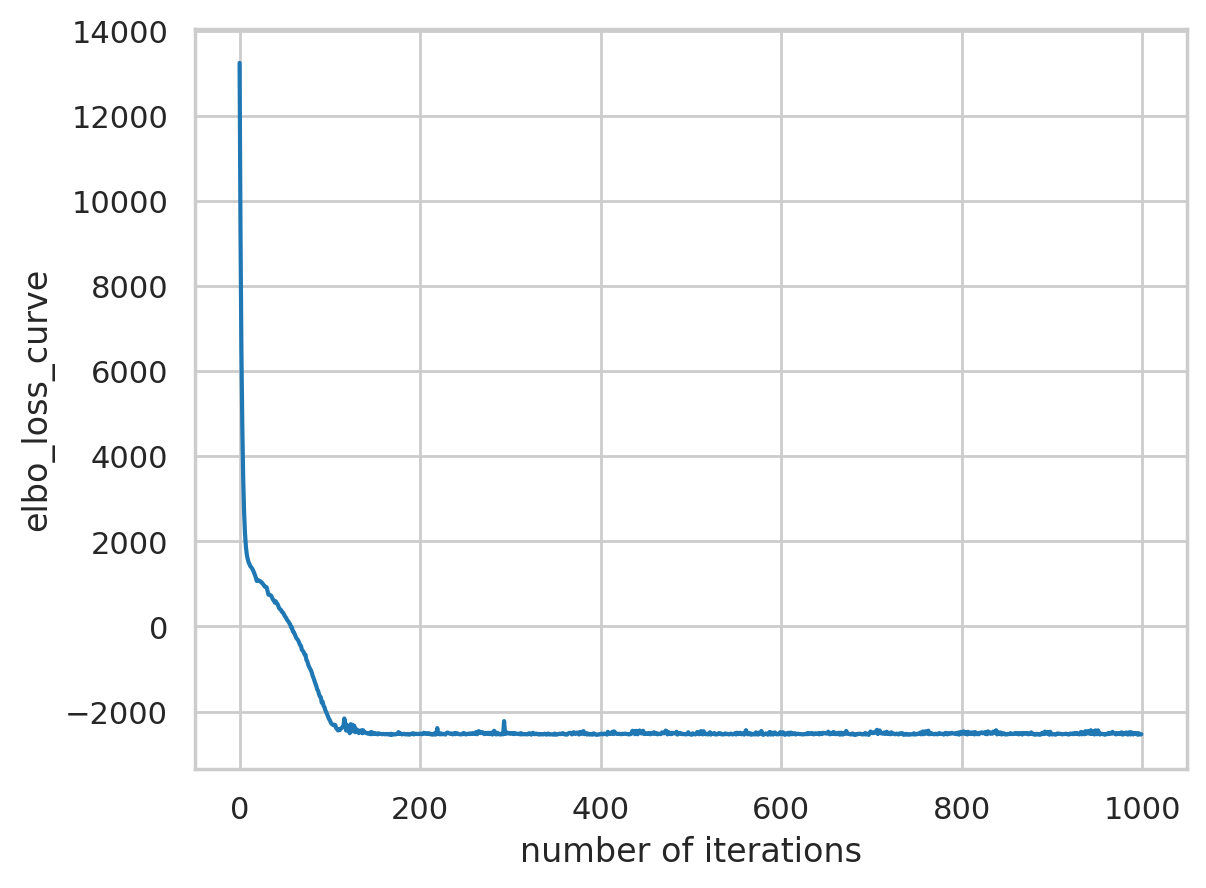

Time elapsed: 479.10 seconds
Inferred parameters:
observation_noise_scale: 0.0025598874781280756 +- 0.002302200999110937
smooth_seasonal/_drift_scale: 0.025013234466314316 +- 0.00047557431389577687
holiday_effects/_weights: [0.15715525 0.00031223 0.01818826] +- [0.01714158 0.01841097 0.01481909]
week_effect/_weights: [-0.00840117 -0.01988406 -0.01671159  0.00459125  0.09639753  0.11335825] +- [0.00313614 0.00206075 0.00297859 0.00220234 0.00301785 0.00320105]
spend_hill_effect/_weights: [0.02727436 0.62067586 0.01537408 0.37137353 0.01773049 0.4369328
 0.02172821 0.6600347  0.02586994 0.3675307  0.05584372 0.6729452
 0.2841018  0.69204473 0.29497728 0.32951733 0.06460981 0.818565
 0.0400301  0.43566298 0.03653798 0.39561072 0.11494166 0.8793027
 0.03025226 0.4223794  0.07809927 0.7196179  0.02680665 0.31246793
 0.01741175 0.38178384 0.1454062  0.542421   0.11675982 0.6145188
 0.31456506 0.85277236 0.01617989 0.4690723  0.04239231 0.19086812
 0.0154779  0.58807254 0.07839943 0.70578104]

In [9]:
import time
start_time = time.time()

# Build the variational surrogate posteriors `qs`.
if 'variational_posteriors' not in globals():
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
        model=sales_model, seed=42
    )

#@t
# 
# 
# itle Minimize the variational loss.
# Allow external control of optimization to reduce test runtimes.

num_variational_steps = 1000 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)
num_samples = 8

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=sales_model.joint_distribution(
    observed_time_series=sales_training_data).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    sample_size=num_samples,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.xlabel("number of iterations")
plt.ylabel("elbo_loss_curve")
plt.show()

# Draw samples from the variational posterior.
q_samples_sales_ = variational_posteriors.sample(50)

print("Time elapsed: {:.2f} seconds".format(time.time() - start_time))

print("Inferred parameters:")
for param in sales_model.parameters:
    print("{}: {} +- {}".format(param.name,
                                np.mean(q_samples_sales_[param.name], axis=0),
                                np.std(q_samples_sales_[param.name], axis=0)))   

config2 for variational_inference

Sample and plot 100 trajectories from the prior.


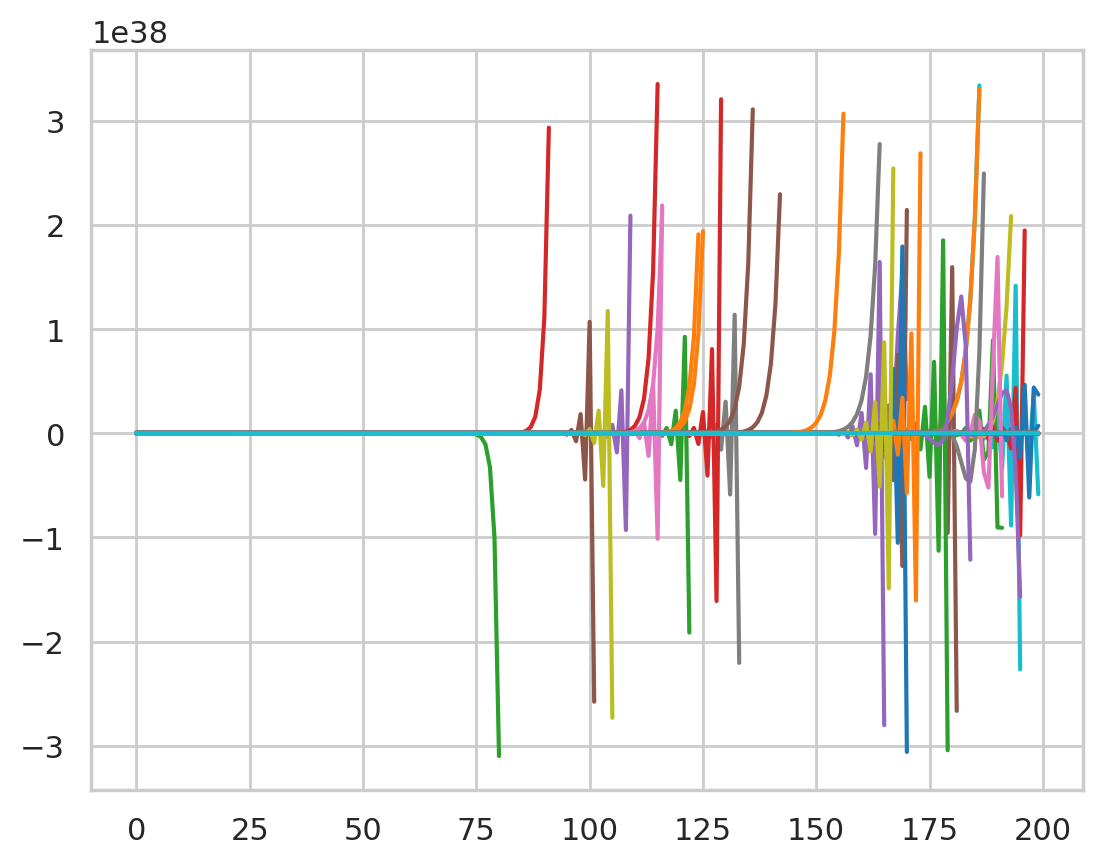

In [13]:
prior_samples = sales_model.joint_distribution(num_timesteps=200).sample([100])
plt.plot(tf.linalg.matrix_transpose(prior_samples['observed_time_series'][..., 0]))

In [10]:
import time
start_time = time.time()


#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 1000 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)
num_samples = 8


jd = sales_model.joint_distribution(observed_time_series=sales_training_data)

# Variational inference.
surrogate_posterior = (
  tfp.experimental.vi.build_factored_surrogate_posterior(
    event_shape=jd.event_shape,
    bijector=jd.experimental_default_event_space_bijector()))


variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
        model=sales_model, seed=42
    )

elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
  target_log_prob_fn=sales_model.joint_distribution(observed_time_series=sales_training_data).unnormalized_log_prob,
  surrogate_posterior=surrogate_posterior,
  optimizer=tf.optimizers.Adam(0.1),
  num_steps=num_variational_steps,
  sample_size=num_samples,
  jit_compile=True)

plt.plot(elbo_loss_curve)
plt.xlabel("number of iterations")
plt.ylabel("elbo_loss_curve")
plt.show()

# Draw samples from the variational posterior.
q_samples_sales_ = variational_posteriors.sample(50)

print("Time elapsed: {:.2f} seconds".format(time.time() - start_time))

print("Inferred parameters:")
for param in sales_model.parameters:
    print("{}: {} +- {}".format(param.name,
                                np.mean(q_samples_sales_[param.name], axis=0),
                                np.std(q_samples_sales_[param.name], axis=0)))

KeyboardInterrupt: 

In [14]:
# Extract the first and second values from each row 
first_values = q_samples_sales_['TotalCost_Digitalturbine_effect/_weights'][:, 0].numpy() 
second_values = q_samples_sales_['TotalCost_Digitalturbine_effect/_weights'][:, 1].numpy() 
 
# Plot the histogram for the first values 
plt.hist(first_values, bins=100, density=True, alpha=0.6, color='blue', label='First Value') 
 
# Plot the histogram for the second values 
plt.hist(second_values, bins=100, density=True, alpha=0.6, color='red', label='Second Value') 

 
plt.xlabel('Value') 
plt.ylabel('Density') 
plt.title('Histograms of the First and Second Values') 
plt.legend() 
plt.show()

KeyError: 'TotalCost_Digitalturbine_effect/_weights'

forcasting


2023-05-06 12:19:35.924139: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 2. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-06 12:19:35.924182: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 5. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-06 12:19:35.924186: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 10. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-06 12:19:35.924189: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 11. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-06 12:19:35.924192: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for 

Compute the MAPE


In [10]:
sales_forecast_dist = tfp.sts.forecast(
    model=sales_model,
    observed_time_series=sales_training_data,
    parameter_samples=q_samples_sales_,
    num_steps_forecast=num_forecast_steps)

true_values = np.exp(sales_scaled['dep_AdjustedInstalls'][-num_forecast_steps:].values)
forecast = np.exp(sales_forecast_dist.mean())
mean_absolute_percentage_error = tf.reduce_mean(tf.abs(forecast - true_values) / true_values) * 100

print(f"Mean absolute percentage error: {mean_absolute_percentage_error:.3f}%")

Mean absolute percentage error: 18.329%


In [22]:
num_samples=100

(
    sales_forecast_mean,
    sales_forecast_scale,
    sales_forecast_samples
) = (
    sales_forecast_dist.mean().numpy()[..., 0],
    sales_forecast_dist.stddev().numpy()[..., 0],
    sales_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

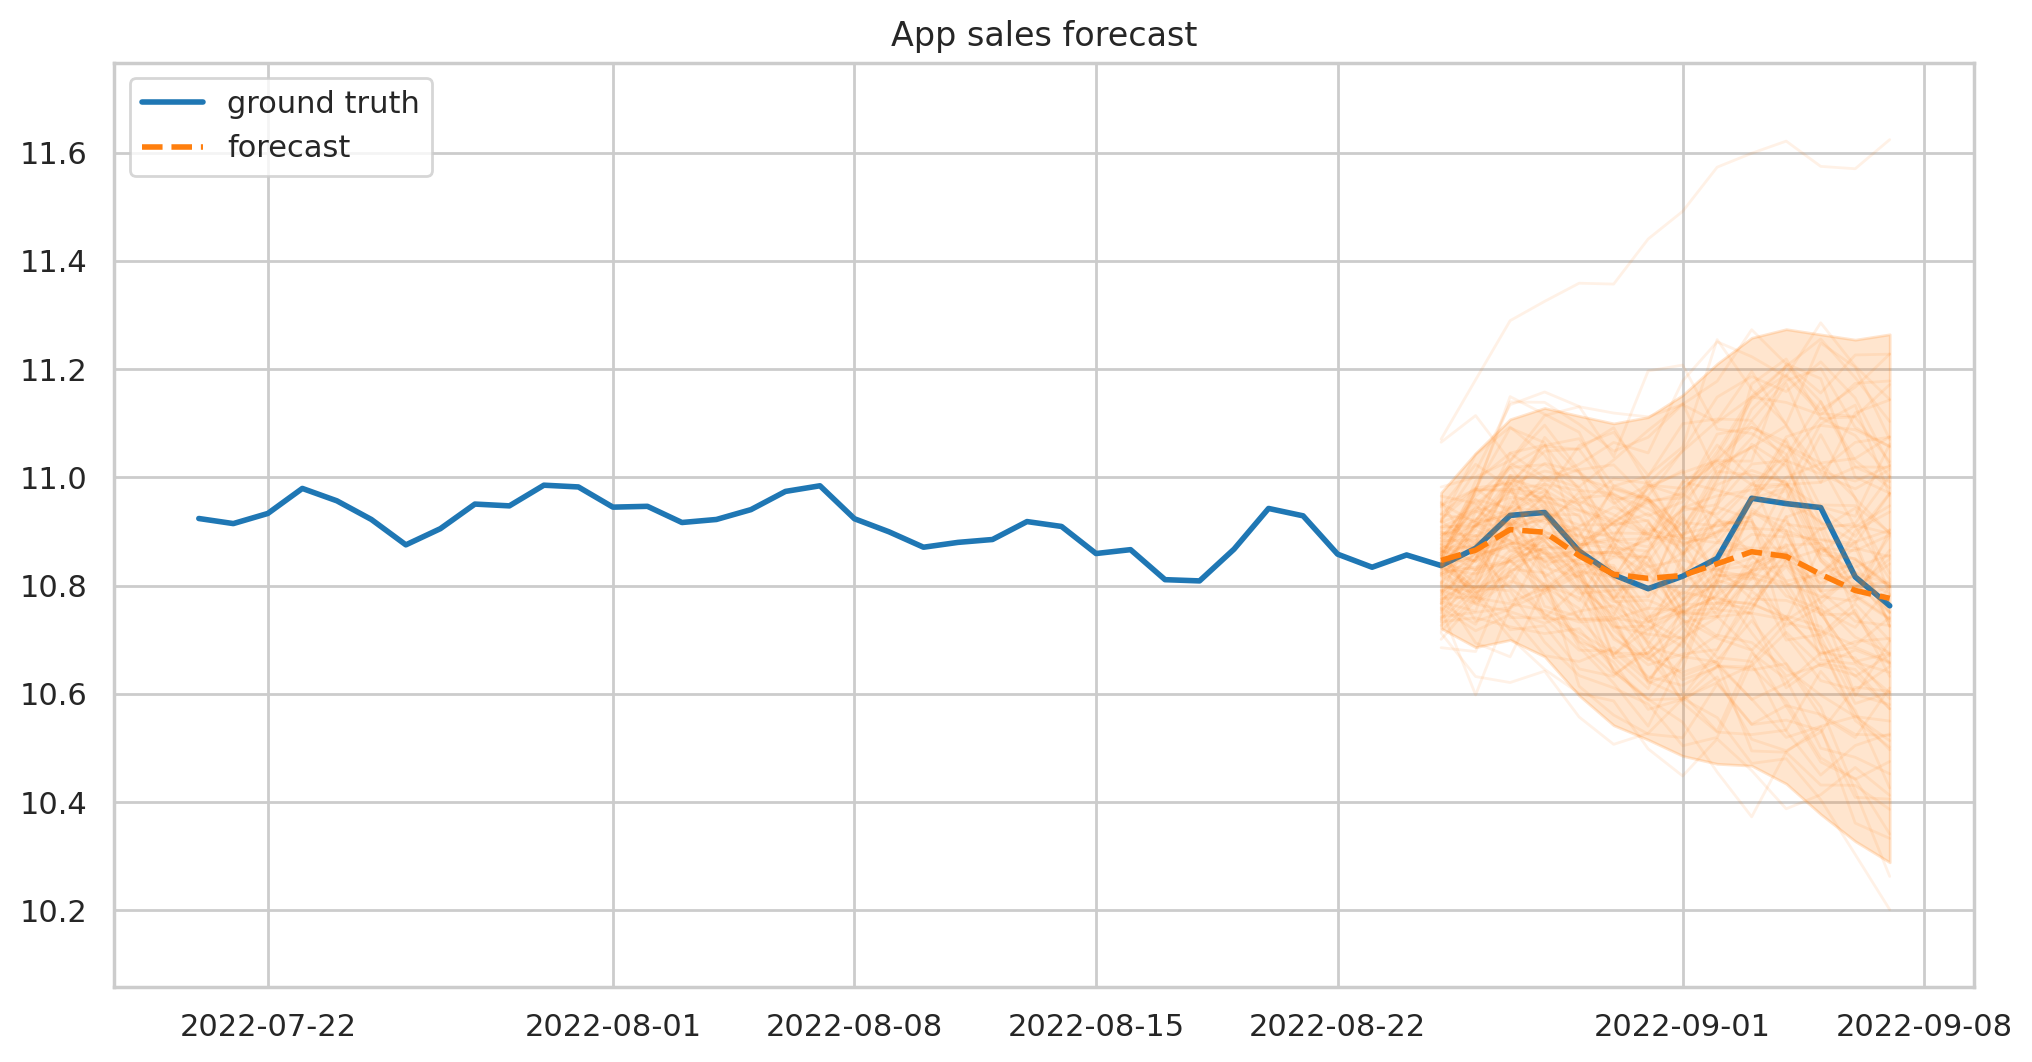

In [23]:
fig, ax = plot_forecast(sales_dates[-50:], sales_scaled['dep_AdjustedInstalls'].values[-50:],
                        sales_forecast_mean,
                        sales_forecast_scale,
                        sales_forecast_samples,
                        title="App sales forecast",
                        x_formatter=sales_fmt)
# ax.set_ylim([8.5, 10.5])
# fig.tight_layout()

In [41]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    sales_model,
    observed_time_series=sales_training_data,
    parameter_samples=q_samples_sales_)

forecast_component_dists = sts.decompose_forecast_by_component(
    sales_model,
    forecast_dist=sales_forecast_dist,
    parameter_samples=q_samples_sales_)

2023-05-04 07:58:38.062110: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 19. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-04 07:58:38.063134: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 2. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-04 07:58:38.063144: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 10. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-04 07:58:38.063148: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 11. The input might not be valid. Filling lower-triangular output with NaNs.
2023-05-04 07:58:38.063151: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for

In [42]:
sales_component_means_, sales_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    sales_forecast_component_means_,
    sales_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

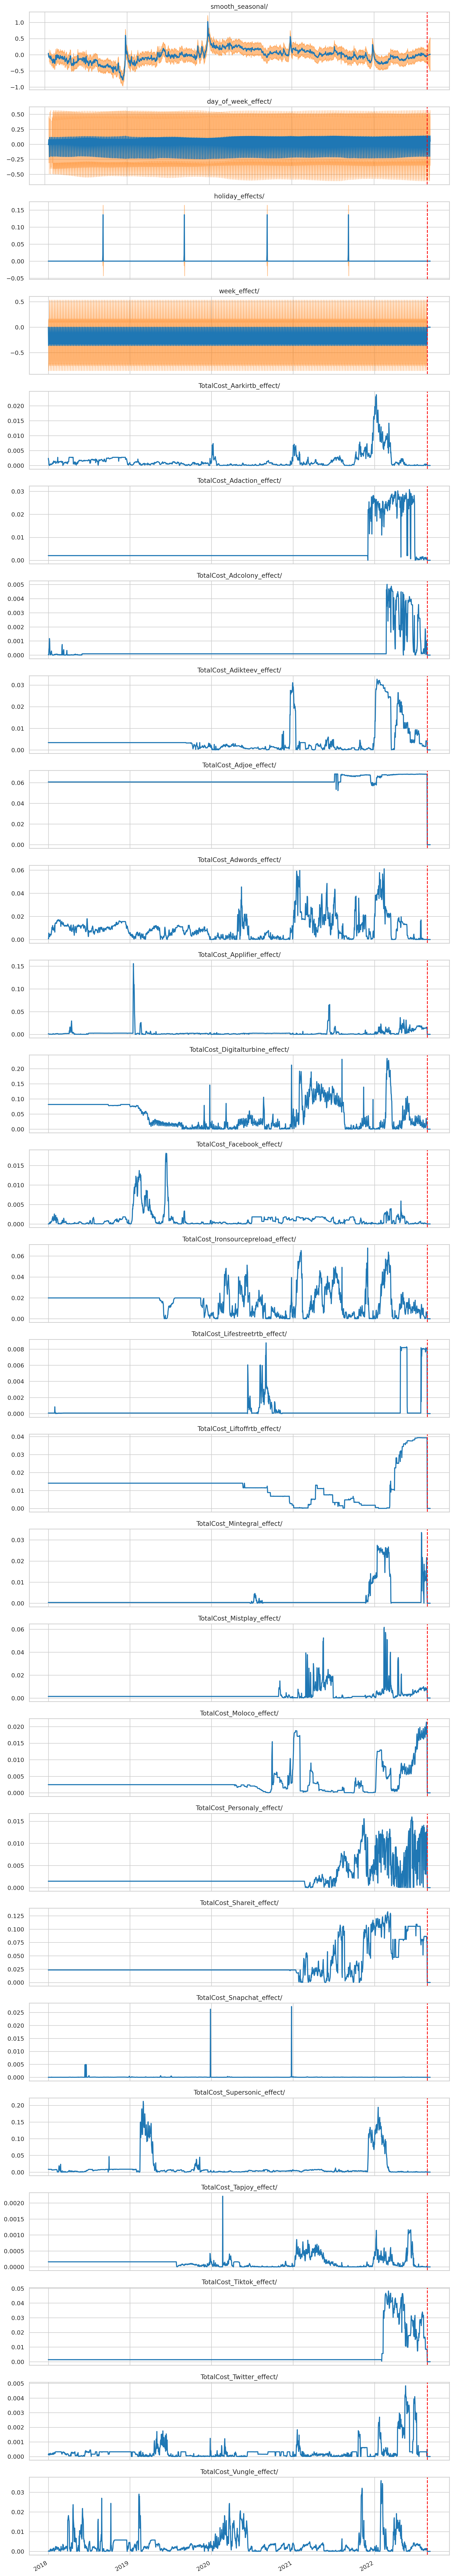

In [32]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in sales_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      sales_component_means_[k],
      sales_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      sales_component_stddevs_[k],
      sales_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
    sales_dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_formatter=sales_fmt)

for ax in axes.values():
  ax.axvline(sales_dates[-num_forecast_steps], linestyle="--", color='red')